In this notebook, we will see the advantage of photonic quantum computing platform from the hardware perspective. 

# Two-state entanglement

We can create entanglement by using the following setup.

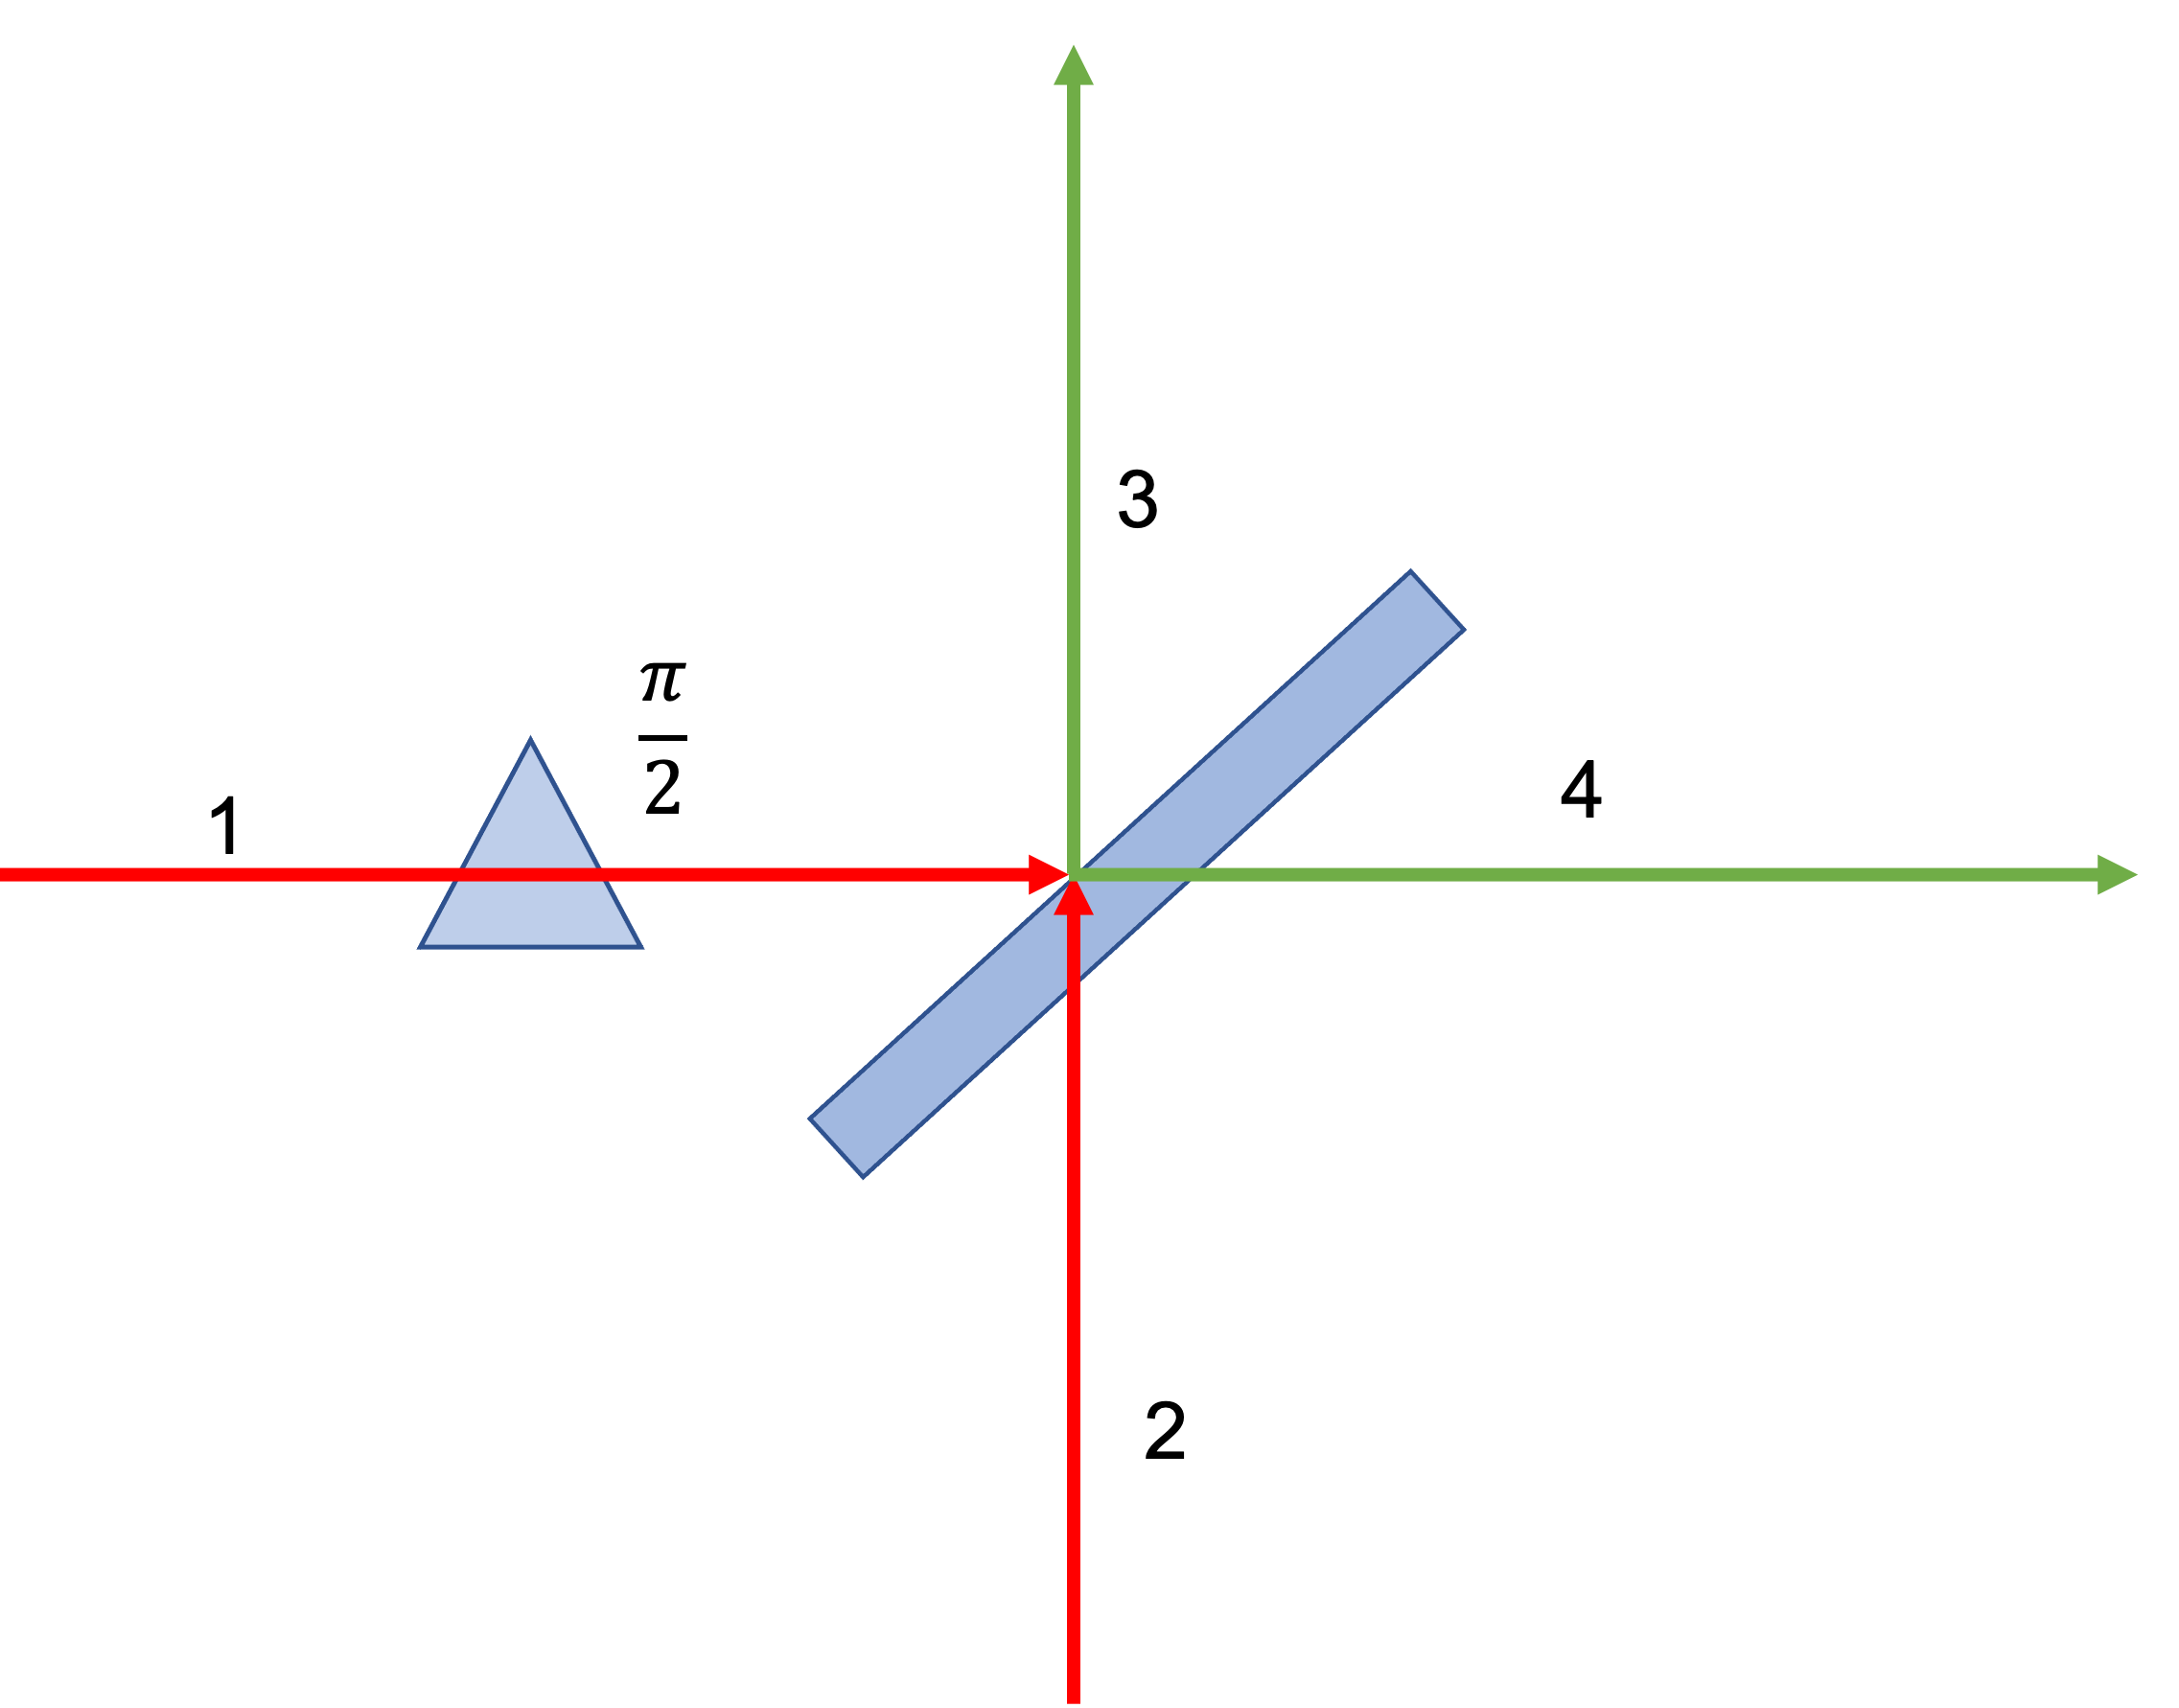

The light in path $1$ and $2$ are squeezed states that are squeezed in the same direction and by the same amount. The squeezed state in path $1$ will go through a $\frac{\pi}{2}$ phase shift before they are combined in the 50:50 beam splitters. The output state in path $3$ and $4$ will have quadratures that are entangled.

We can verify this property by building the circuits.

In [1]:
import numpy as np
import strawberryfields as sf
from strawberryfields.ops import *
from matplotlib import pyplot as plt

In [4]:
prog= sf.Program(2)

with prog.context as q:
    #generate state 1 and 2
    Squeezed(r=1, p=0) | q[0] 
    Squeezed(r=1, p=0) | q[1]
    #apply phase shift to state 1
    Rgate(np.pi/2)|q[0]
    #combine in 50:50 beam splitter
    BSgate() | (q[0], q[1])
    #measure the quadrature
    MeasureHomodyne(0) | q[0]
    MeasureHomodyne(0) | q[1]
eng = sf.Engine("gaussian")

n=1000

#do for 1000 times
q1=np.zeros(n)
q2=np.zeros(n)
for i in range(0,n):
    result = eng.run(prog)
    q1[i]=result.samples[0][0]
    q2[i]=result.samples[0][1]

In [5]:
print(q1[0:5])
print(q2[0:5])

[-1.62248944 -2.49147977  0.41180679  1.14504532 -2.45174119]
[-1.3541953  -1.31266324  1.00364245  0.96956534 -2.68757061]


We can see that when we measure the quadrature from state $3$ and $4$, the quadratures will be correlated to each other, as we would expect from entangled state. We can measure the variance of the quadrature difference.

In [6]:
np.var(np.abs(q1-q2))

0.09332488992496413

When we plot the quadratures, we can see the correlation.

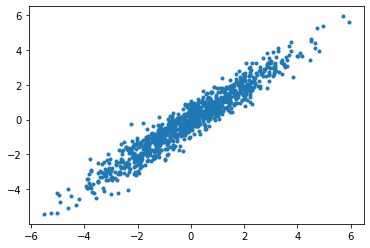

In [8]:
plt.plot(q1,q2,'.');

We can increase the squeezing in the input state and we will observed that the correlation is improved as the variance of the quadrature difference decreased.

In [ ]:
#quiz: what happens if we increase the squeezing of input state?

In [10]:
prog= sf.Program(2)

with prog.context as q:
    #generate state 1 and 2
    Squeezed(r=10, p=0) | q[0] 
    Squeezed(r=10, p=0) | q[1]
    #apply phase shift to state 1
    Rgate(np.pi/2)|q[0]
    #combine in 50:50 beam splitter
    BSgate() | (q[0], q[1])
    #measure the quadrature
    MeasureHomodyne(0) | q[0]
    MeasureHomodyne(0) | q[1]
eng = sf.Engine("gaussian")

n=1000

#do for 1000 times
q1=np.zeros(n)
q2=np.zeros(n)
for i in range(0,n):
    result = eng.run(prog)
    q1[i]=result.samples[0][0]
    q2[i]=result.samples[0][1]

print(np.var(np.abs(q1-q2)))

2.249127101010024e-08


# Time-domain circuit

We can put the circuit above in a loop configuration.

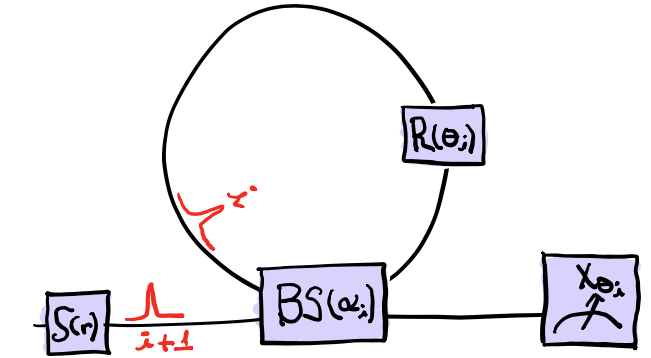

We can do the following steps:
1. At $t_0$, we send the a state through the squeezing gate (this will be the input state $1$)
2. At $t_1$, this state will go through beam splitter and be reflected to the loop
3. At $t_2$, the state $1$ will pass through the rotation gate and we will send another state that to the squeezing gate (this will be the input state $2$)
4. At $t_3$, both the state $1$ and $2$ will arrive at the beam splitter gate at the same time, where both of the states are squeezed and state $1$ have additional $\frac{\pi}{2}$ phase shift. This condition is now equivalent to the circuit that generates entanglement above
5. At $t_4$, we measure the states with homodyne detector

This may seem unuseful at the first glance, but imagine if we want to create $n$ entangled states. In the conventional quantum computing platform, the circuit will grow larger as $n$ increases. But in here, the circuit area will be the same.

If we want to have $n$ entangled states, then what we have to do is just to repeat the loop above for $n$ times and just tune the parameter of the transmittivity in the beam splitter and the angle in rotation gate. This is reconfigurable and we can make any number of entangled states.

In here, we are using the time-bin as our qumodes, so we can multiplex the time-bin in time domain while conserving the space, hence the name time-domain circuit.

# N state entanglement

To create the $n$ state entanglement, the beam splitter at round $i$ will have transmittivity:

\begin{equation}
  transmittivity=\begin{cases}
    \sqrt{\frac{1}{n-i+1}}, & \text{if $0\leq i \leq n$}.\\
    0, & \text{n+1}.
  \end{cases}
\end{equation}

$$
\alpha=\cos^{-1}(transmittivity)
$$

And the rotation gate at round $i$ will have angle:

\begin{equation}
  \theta=\begin{cases}
    0, & \text{if i=0}.\\
    \frac{\pi}{2}, & \text{$1\leq i \leq n$}.
  \end{cases}
\end{equation}

In [22]:
theta = [0] * (
    n + vac_modes
) 
theta

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [31]:
n=6
prog= sf.Program(n)

vac_modes = 1  # This is an ancilla mode that is used at the beginning of the protocol
shots = 1
r = 4
alpha = [
    np.arccos(np.sqrt(1 / (n - i + 1))) if i != n + 1 else 0
    for i in range(n + vac_modes)
]

phi = [0] * (n + vac_modes)
phi[0] = np.pi / 2
theta = [0] * (
    n + vac_modes
)  # We will measure first all the states in the X quadrature


with prog.context as q:
    for i in range(0,n-1):
        Sgate(r) | q[i + 1]
        BSgate(alpha[i]) | (q[i], q[i + 1])
        Rgate(phi[i]) | q[i + 1]
        MeasureHomodyne(theta[i]) | q[i]
eng = sf.Engine("gaussian")

n=1000

#do for 1000 times
q1=np.zeros(n)
q2=np.zeros(n)
q3=np.zeros(n)
q4=np.zeros(n)
q5=np.zeros(n)
for i in range(0,n):
    result = eng.run(prog)
    q1[i]=result.samples[0][0]
    q2[i]=result.samples[0][1]
    q3[i]=result.samples[0][2]
    q4[i]=result.samples[0][3]
    q5[i]=result.samples[0][4]

In [32]:
print(q1[0:10])

[-0.39756116 -0.33423887 -0.17657382  0.66938331 -0.06821534 -0.02856347
 -0.12738303 -0.99029029  0.43981771  0.07696086]


In [33]:
print(q2[0:10])

[12.42959111 -5.10195018  0.53543735  3.31382289 -0.20417433 -0.1611422
 -5.38682923 21.61135591 -2.63818615 20.74348181]


In [34]:
print(q3[0:10])

[12.38980046 -5.11282735  0.54710789  3.31015271 -0.20228786 -0.15211116
 -5.38159891 21.63511308 -2.68122519 20.74008438]


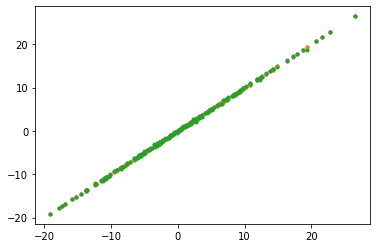

In [37]:
plt.plot(q2,q3,'.');
plt.plot(q2,q4,'.');
plt.plot(q2,q5,'.');

# More efficient time-domain circuit